In [217]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
import datetime 
import scipy.optimize as sco
import scipy.interpolate as sci
from pylab import plt, mpl
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot

In [2]:
from arch import arch_model

In [3]:
plt.style.use('seaborn')

https://www.bankrate.com/investing/best-etfs/ 

Invesco QQQ Trust (QQQ) - Non-financial Nasdaq - Tech-heavy

iShares Core S&P 500 ETF (IVV) - Black Rock - very low cost

ProShares VIX Short-Term Futures ETF (VIXY) - ETF on VIX (volatility)

Vanguard High Dividend Yield (VYM) - FTSE high-dividend paying stocks

Vanguard Health Care Index Fund (VHT)

https://www.thebalance.com/best-etfs-4173857

iShares Russell 2000 ETF (IWM) - Small cap stock

SPDR Gold Trust (GLD)

Vanguard FTSE Developed Markets (VEA) - Develeoped contries except USA




Vanguard FTSE Europe Index Fund ETF Shares (VGK)

iShares Short Treasury Bond ETF (SHV)

iShares 20+ Year Treasury Bond ETF (TLT)

iShares Core € Corp Bond UCITS ETF (IEAC)

In [4]:
# List shares of interest as Yahoo Fiance "Ticker"/"Symbol"
mylist = ['QQQ', 'IVV', 'VIXY', 'VYM', 'VHT', 'IWM', 'GLD', 'VEA', 'VGK', 'SHV', 'TLT']
        # ["danske.co", "MAERSK-B.CO", 'CHR.CO', "NZYM-B.CO", 'LUN.CO', 'GN.CO', 'CARL-B.CO', 'GEN.CO', 'ORSTED.CO']
noa = len(mylist)

# Create DataFrame to store data
df = pd.DataFrame()
df_change = pd.DataFrame()
rets = pd.DataFrame()

In [5]:
for x in mylist:
    df[x] = pdr.get_data_yahoo(x, start=datetime.datetime(2011, 1, 1))['Adj Close'] 
    df_change['pct_c_{}'.format(x)] = df[x].pct_change()   # 
    rets[x] = np.log(df[x] / df[x].shift(1))

In [6]:
rets.describe().round(4)

,QQQ,IVV,VIXY,VYM,VHT,IWM,GLD,VEA,VGK,SHV,TLT
count,2154.0000,2154.0000,2153.0000,2154.0000,2154.0000,2154.0000,2154.0000,2154.0000,2154.0000,2154.0000,2154.0000
mean,0.0006,0.0005,-0.0028,0.0005,0.0006,0.0004,-0.0000,0.0002,0.0002,0.0000,0.0003
std,0.0108,0.0091,0.0399,0.0080,0.0097,0.0118,0.0098,0.0108,0.0124,0.0001,0.0084
min,-0.0621,-0.0670,-0.1407,-0.0546,-0.0582,-0.0911,-0.0919,-0.0854,-0.1198,-0.0006,-0.0518
25%,-0.0039,-0.0032,-0.0242,-0.0030,-0.0039,-0.0054,-0.0049,-0.0047,-0.0052,-0.0001,-0.0048
50%,0.0010,0.0006,-0.0058,0.0005,0.0010,0.0011,0.0003,0.0007,0.0007,0.0000,0.0007
75%,0.0064,0.0051,0.0143,0.0048,0.0061,0.0070,0.0049,0.0060,0.0069,0.0001,0.0054
max,0.0606,0.0502,0.2944,0.0387,0.0453,0.0645,0.0479,0.0644,0.0805,0.0005,0.0389


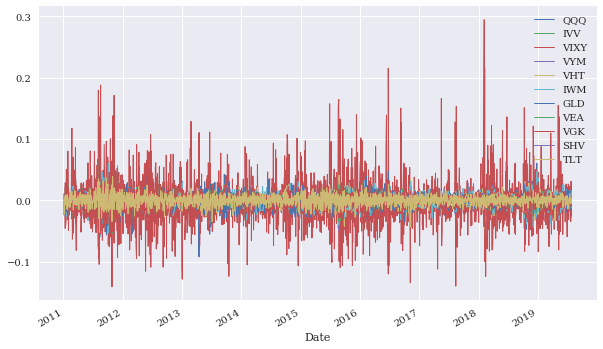

In [7]:
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
rets.plot(lw=1.0, figsize=(10,6))  #.cumsum()

In [8]:
# Random assigned weight
weights = np.random.random(noa)
weights /= np.sum(weights) 
weights

array([0.12368817, 0.11917545, 0.07344329, 0.09545882, 0.06495627,
       0.12834034, 0.02376716, 0.11085999, 0.1301572 , 0.02786899,
       0.10228433])

In [9]:
# Expected portfolio return (annualized)
EPR = np.sum(rets.mean() * weights) * 252

# Portfolio Variance annualized
PV = np.dot(weights.T, np.dot(rets.cov() * 252, weights))

# Portfolio Volatility (Standard deviation)
P_std = math.sqrt(PV)

display(EPR, PV, P_std)

0.032448023432603335

0.00645246207672886

0.08032721877874809

In [10]:
# Monte Carlo simulation

def port_ret(weights):
    return np.sum(rets.mean() * weights) *252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    
p_rets = []
p_vols = []
    
for p in range (50000):
    weights = np.random.random(noa)
    weights /= np.sum(weights) 
    p_rets.append(port_ret(weights))
    p_vols.append(port_vol(weights))
    
p_rets = np.array(p_rets)
p_vols = np.array(p_vols)

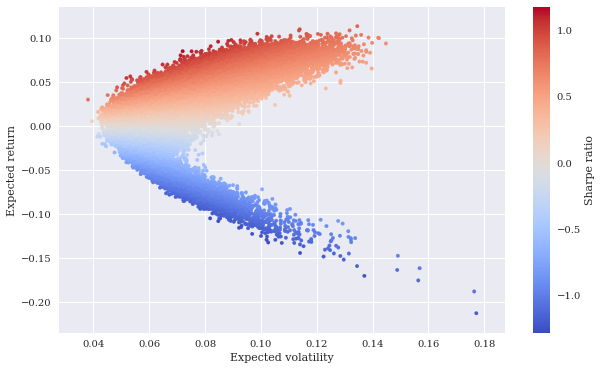

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker = '.', cmap='coolwarm')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

In [14]:
# Maximisation of Sharpe Ratio 

# Function to minimize
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

# Equality constraint
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for parameters
bnds = tuple((0,1) for x in range(noa))

# Equal weights 
eweights = np.array(noa * [1. / noa,])

print('Equal weight sharp ratio = ', -min_func_sharpe(eweights).round(4))

Equal weight sharp ratio =  0.1307


In [16]:
# Max return
#%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
#print(opts)
print('opts = opt. port. weights = ', opts['x'].round(3))
print('port_ret = ', port_ret(opts['x']).round(3))
print('port_vol = ', port_vol(opts['x']).round(3))
print('Maximum Sharpe Ratio = ', port_ret(opts['x']) / port_vol(opts['x']))

opts = opt. port. weights =  [0.002 0.    0.    0.004 0.003 0.    0.    0.    0.    0.986 0.005]
port_ret =  0.007
port_vol =  0.002
Maximum Sharpe Ratio =  2.8256781884731503


In [18]:
# Minimize Vol
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
print('weights = ', optv['x'].round(3))
print('Minimum vol = ', port_vol(optv['x']).round(3))
print('return = ', port_ret(optv['x']).round(3))
print('Sharpe ratio = ', (port_ret(optv['x']) / port_vol(optv['x'])).round(3))

weights =  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.999 0.   ]
Minimum vol =  0.002
return =  0.005
Sharpe ratio =  2.529


In [19]:
# Effecient Frontier pp. 224

# Binding Constraint for efficient frontier
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds
bnds = tuple((0,1) for x in weights)

# Target Return
trets = np.linspace(0.0, 0.15, 50) # We want to find minimum vol portfolios to each target return (trets).

tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])

# Store tvols as numpy array
tvols = np.array(tvols)


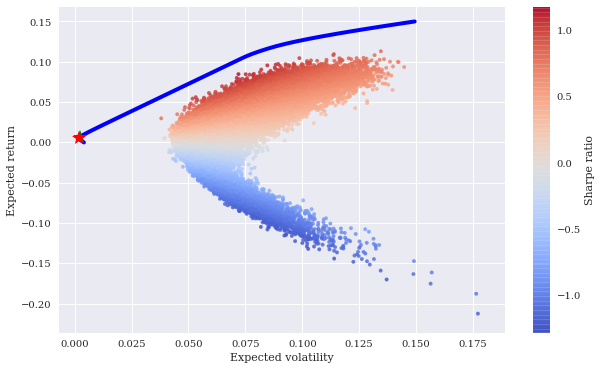

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'g*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

In [30]:
# Capital Market Line pp. 425

# Index position of minimum vol portfolio
ind = np.argmin(tvols)
evols = tvols[ind:]     # Relevant portfolio vol
erets = trets[ind:]     # Relevant portfolio ret

tck = sci.splrep(evols, erets)   # Cubic splines interpolation on these values

def f(x):
    '''Effecient frontier function (splines approximation).'''
    return sci.splev(x, tck, der=0)

def df(x):
    '''First derivative of Efficient frontier fct.'''
    return sci.splev(x, tck, der=1)

In [46]:
# page 427
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.2, 0.1])

print('Optimal parameter values = ', opt.round(4))

print('Check that eq holds:', np.round(equations(opt), 6))

Optimal parameter values =  [0.01   1.2847 0.0747]
Check that eq holds: [ 0. -0. -0.]


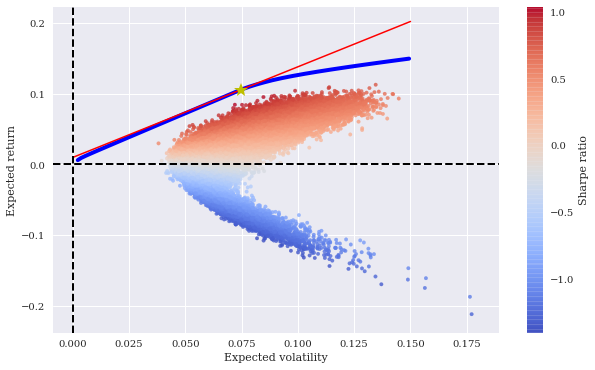

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=(p_rets-0.01) / p_vols,                      # Check rf = 0.01
            marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)

cx = np.linspace(0.0, 0.15)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)

plt.plot(opt[2], f(opt[2]), 'y*', markersize=15)

plt.grid(True)

plt.axhline(0,color='k', ls='--', lw=2.0)
plt.axvline(0,color='k', ls='--', lw=2.0)

plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

In [49]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - f(opt[2])},
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1})

res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)

In [50]:
res

     fun: 0.07468355074780236
     jac: array([ 1.15218342e-01,  9.44613796e-02, -3.57171087e-01,  8.30115220e-02,
        1.05338224e-01,  1.06449896e-01,  1.91911897e-02,  8.87492280e-02,
        9.30368667e-02,  6.96443021e-05,  4.46439963e-02])
 message: 'Optimization terminated successfully.'
    nfev: 169
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([1.43853740e-01, 2.33103467e-18, 0.00000000e+00, 2.53612014e-01,
       1.67342220e-01, 2.49908601e-17, 3.17434067e-17, 1.57209315e-18,
       5.58364119e-18, 1.29426634e-18, 4.35192026e-01])

In [57]:
print('weights:',res['x'].round(3))
print('return',port_ret(res['x']).round(4))
print('vol',port_vol(res['x']).round(4))

weights: [0.144 0.    0.    0.254 0.167 0.    0.    0.    0.    0.    0.435]
return 0.106
vol 0.0747


## Moving on to GARCH modelleing

'TLT'

<function __main__.port_ret(weights)>

In [202]:
squared_rets = rets ** 2

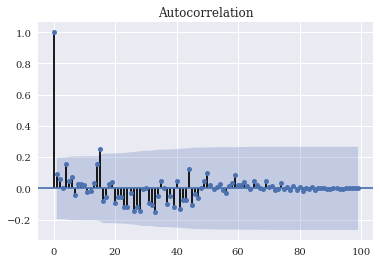

In [210]:
plot_acf(squared_rets['QQQ'][-100:])
pyplot.show()

In [211]:
# define GARCH model
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15)

NameError: name 'arch_model' is not defined